## Generate a PSD plot framework for future plots.

In [1]:
#Purisa Jasmine Simmons
#Viren Abhyankar
#February 2020

#Overview: Trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from Scripps buoy that recalibrates every 30 minutes 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added
import statistics #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [2]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets all columns

motion_df = pd.read_csv('Scripps_Final_Combined_DS_1Hz.csv')


#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

   Unnamed: 0                                                 ID  \
0           0  google_106807627751629413403_0006667E228C_1709...   
1           4  google_106807627751629413403_0006667E228C_1709...   
2           8  google_106807627751629413403_0006667E228C_1709...   
3          13  google_106807627751629413403_0006667E228C_1709...   
4          17  google_106807627751629413403_0006667E228C_1709...   

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   
2  2017-09-09T18:02:13.0800+00:00  18:02  0.517148   6.876147  0.919373   
3  2017-09-09T18:02:13.9310+00:00  18:02  0.574608  11.051635  0.497994   
4  2017-09-09T18:02:14.7810+00:00  18:02  0.134075   9.768343  0.536301   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3      Date  \
0  46.829268  15.853659  15.487805     -37    -199     517  9/9/2017

## Make a copy of the original motion_df dataframe

In [3]:
saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data included

## Calcualting time elapsed

In [4]:
#Analyze particular UTC with actual heights (m) -- 30 minute sessions
# 2017-09-09T18:24:00.1810+00:00 to 2017-09-09T18:54:00.1810+00:00 -- 0.810768
# 2017-09-09T18:54:00.1810+00:00 to 2018-06-14T15:13:06.7140+00:00 -- 0.819912
# 2018-06-14T15:13:06.7140+00:00 to 2018-06-14T15:43:00.0050+00:00 -- 0.679704
# 2018-06-14T15:43:00.0050+00:00 to 2018-06-14T16:13:00.2150+00:00 -- 0.70104
# 2019-05-29T15:21:41.0170+00:00 to 2019-05-29T15:51:00.0140+00:00 -- 1.069848
# 2019-05-29T15:51:00.0140+00:00 to 2019-05-29T16:21:00.0620+00:00 -- 1.179576
# 2019-05-29T16:21:00.0620+00:00 to 2019-05-29T16:51:00.1630+00:00 -- 1.179576


START = '2017-09-09T18:02:11.2810+00:00'
END = '2017-07-02T02:57:24.5670+00:00'



time_array = []
utc_time = motion_df[['UTC']].to_numpy()

start_index = np.where(utc_time==START)[0][0]
end_index = np.where(utc_time==END)[0][0]

length = end_index-start_index

mins_per_measure = 60/length
sec_per_measure = 60*mins_per_measure

for i in range(0, length):
    time_array.append(sec_per_measure*i)

# Parse through dataset

In [5]:
# Function to parse time string and calculate half hour
def add_half_hour(time_str):
    # Parse string
    hrs = int(time_str[:2])
    mins = int(time_str[3:5])
    
    # Set minutes and hours
    if (mins < 30):
        mins += 30
    else:
        mins -= 30
        if (hrs == 23):
            hrs = 0
        else:
            hrs += 1
            
    # Check if mins and hrs are single digits
    if (mins < 10):
        mins = '0'+str(mins)
    if (hrs < 10):
        hrs = '0'+str(hrs)
        
    return str(hrs)+':'+str(mins)

# Parse int and compare functions in case we need them in the future

def parse_int(time_str):
    return 60*int(time_str[:2])+int(time_str[3:5])

def is_less_than_eq(str1, str2):
    if (str1[:2]=='23' and str2[:2]=='00'):
        return True
    
    str1 = parse_int(str1)
    str2 = parse_int(str2)
    
    return (str1 <= str2)


In [6]:
%%time

### Goal: create an array of arrays of IMU A2 data ###
surf_sessions = []
height_labels = []
utc_labels = []
date_labels = []

## Step 1: get 5 columns of the data frame to iterate over - ID, Time, IMU A2, Date, Height ##
df_parser = motion_df[['ID', 'UTC', 'Time', 'IMU A2', 'Date', 'Hs(m)']]

# Convert to numpy array
id_parser = df_parser[['ID']].to_numpy()
time_parser = df_parser[['Time']].to_numpy()
utc_parser = df_parser[['UTC']].to_numpy()
imuA2_parser = df_parser[['IMU A2']].to_numpy()
date_parser = df_parser[['Date']].to_numpy()
height_parser = df_parser[['Hs(m)']].to_numpy()

## Step 2: loop through every data point ##
working_array = []
skip_check = '00:00'
end_index_check = None

for start_index in range(0, len(id_parser)):
    ## Goal 1: Append IMU data if we are in the half-hour segment ##
    if (end_index_check != None):
        # Check if we've reached the end of the half hour before appending
        if (start_index==end_index_check):
            surf_sessions.append(working_array)
            working_array = []
            end_index_check = None
        else:
            working_array.append(imuA2_parser[start_index][0])
        continue
        
    ## Goal 2: Check if height of current and half-hour times are equal ##
    start = time_parser[start_index][0]
    
    # Skip through a minute if it has already been checked and invalidated
    if (start==skip_check):
        continue
        
    # Set end point
    end = add_half_hour(start)
    
    # Check if ride is still valid for half hour time
    try:
        # End index is where the time is equal to end and we are in the same ride as we started
        end_index = np.where((time_parser==end) & (id_parser==id_parser[start_index]))[0][0]
    except IndexError:
        # Skip through minutes
        skip_check = start
        continue
    else:
        # (occurs after try block) skip if the heights don't match
        if (height_parser[start_index]!=height_parser[end_index-1]):
            skip_check = start
        else:
            # add to array if heights do match
            working_array.append(imuA2_parser[start_index][0])
            height_labels.append(height_parser[start_index][0])
            utc_labels.append(utc_parser[start_index][0])
            date_labels.append(date_parser[start_index][0])
            
            end_index_check = end_index
            skip_check = '00:00'

            
            print("Session: ", len(surf_sessions)+1, ", Date: ", date_parser[start_index][0])
            print("At ", start, " and ", end)
            print("Start: ", height_parser[start_index], " and End: ", height_parser[end_index-1], "\n")

print("Total sessions: ", len(surf_sessions))
print("Total heights: ", len(height_labels))


Session:  1 , Date:  9/9/2017
At  18:10  and  18:40
Start:  [0.810768]  and End:  [0.810768] 

Session:  2 , Date:  9/9/2017
At  18:40  and  19:10
Start:  [0.819912]  and End:  [0.819912] 

Session:  3 , Date:  6/14/2018
At  15:20  and  15:50
Start:  [0.70104]  and End:  [0.70104] 

Session:  4 , Date:  6/14/2018
At  15:50  and  16:20
Start:  [0.710184]  and End:  [0.710184] 

Session:  5 , Date:  5/29/2019
At  15:50  and  16:20
Start:  [1.069848]  and End:  [1.069848] 

Session:  6 , Date:  5/29/2019
At  16:20  and  16:50
Start:  [1.179576]  and End:  [1.179576] 

Session:  7 , Date:  8/12/2018
At  14:46  and  15:16
Start:  [0.618744]  and End:  [0.618744] 

Session:  8 , Date:  8/12/2018
At  15:20  and  15:50
Start:  [0.649224]  and End:  [0.649224] 

Session:  9 , Date:  8/8/2017
At  16:40  and  17:10
Start:  [0.920496]  and End:  [0.920496] 

Session:  10 , Date:  8/8/2017
At  17:10  and  17:40
Start:  [0.911352]  and End:  [0.911352] 

Session:  11 , Date:  8/8/2017
At  17:40  and

ValueError: invalid literal for int() with base 10: '0:'

### Bandpass filter the data

In [7]:
#First integral of acc to get velocity:
from scipy import integrate

def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t >= low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array


In [8]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [9]:
# Define the sample rate and the Low and High Cutoff frequencies

fs = 5 #redefine the sampling frequency

order=6
lowcut = 0.09
highcut = 1.0

def double_integral_bandpass(time_array, acc_array, dacc_array, lowcut, highcut, fs, order):
    
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)



    f1 = plt.figure(figsize=(12,5))
    ax1 = f1.add_subplot(121)
    ax2 = f1.add_subplot(122)

    f2 = plt.figure(figsize=(12,5))
    ax3 = f2.add_subplot(121)
    ax4 = f2.add_subplot(122)
    
    f3 = plt.figure(figsize=(12,5))
    ax5 = f3.add_subplot(121)
    ax6 = f3.add_subplot(122)

    #Acceleration graphs:
    ax1.plot(time_array, dacc_array)
    ax1.set_title('Detrended Acceleration vs. Time')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Velocity [m/s]')
    ax1.axhline(0, color="orange", ls='--')
    
    ax2.plot(time_array, butter_lfilter)
    ax2.set_title('Butter Filtered Detrended Acceleration vs. Time')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.axhline(0, color="orange", ls='--')
    
    #Velocity graphs:
    ax3.plot(time_array, v_butter_filter_integral)
    ax3.set_title('Butter Filtered Velocity vs. Time')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Velocity [m/s]')
    ax3.axhline(0, color="orange", ls='--')


    ax4.plot(time_array, detrend_v_integral)
    ax4.set_title('Butter Filtered Detrended Velocity vs. Time')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Velocity [m/s]')
    ax4.axhline(0, color="orange",ls='--')

    
    #Displacement graphs:
    ax5.plot(time_array, disp_butter_filter_integral)
    ax5.set_title('Butter Filtered Displacement vs. Time')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Displacement [m]')               
    
    ax6.plot(time_array, detrend_disp_butter_integral)
    ax6.set_title('Detrended Butter Filtered Displacement vs. Time')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement [m]')


    plt.show()
    
    return detrend_disp_butter_integral

# Detrend on entire data

In [10]:
# Function to calculate percent error
def percent_error(actual, expected):
    return 100*(abs(actual-abs(expected))/actual)

Starting full data set analysis:


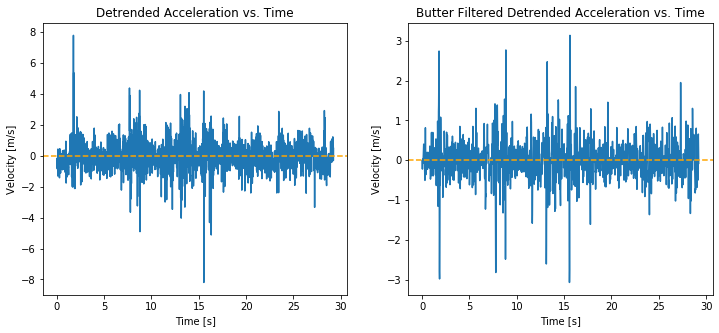

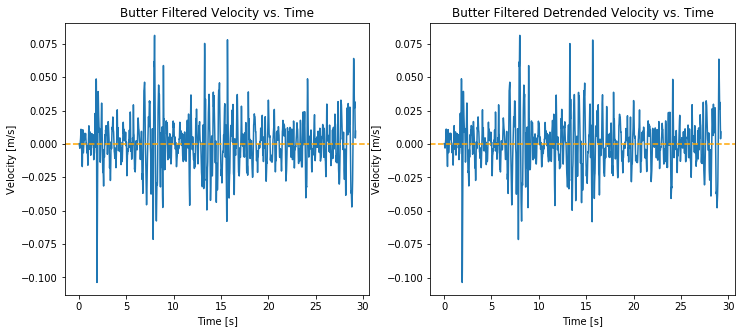

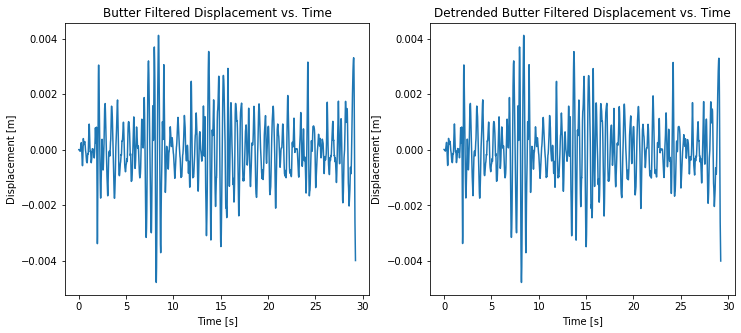

Done.
Significant wave height calculated as:  0.7216037307382166  for session  1
Actual wave height:  0.810768
Percent error:  10.997507210667349


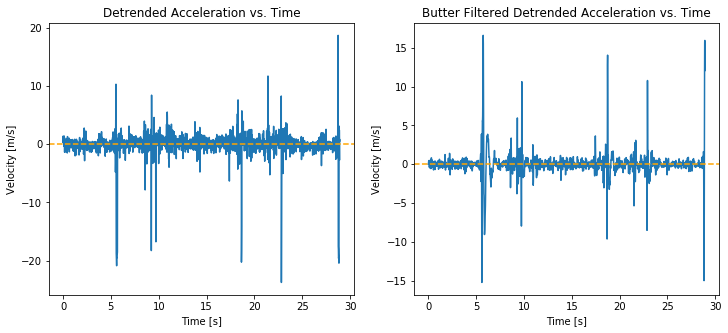

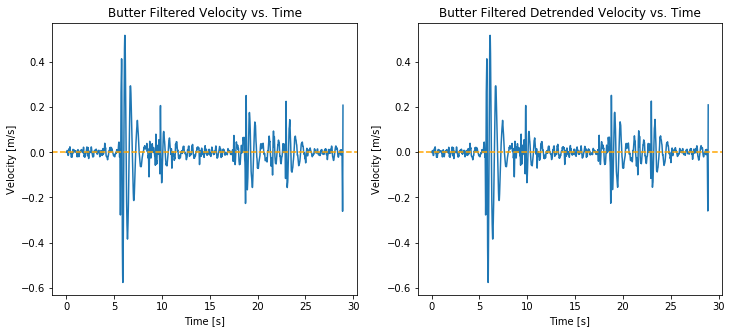

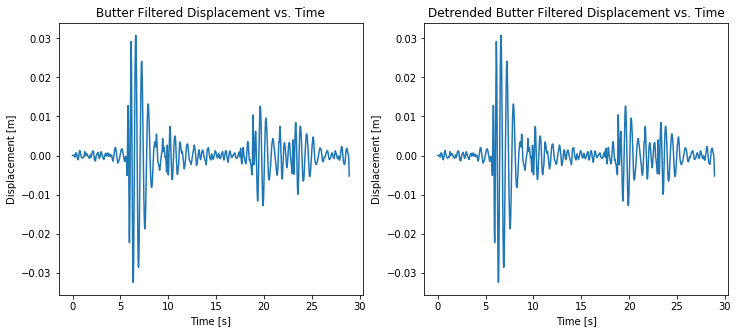

Done.
Significant wave height calculated as:  1.0339037926286831  for session  2
Actual wave height:  0.8199120000000001
Percent error:  26.099360983701057


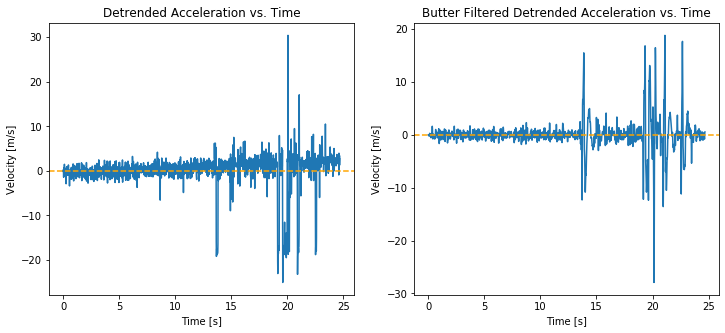

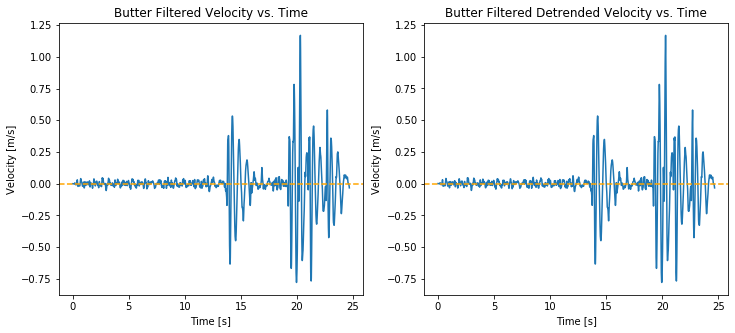

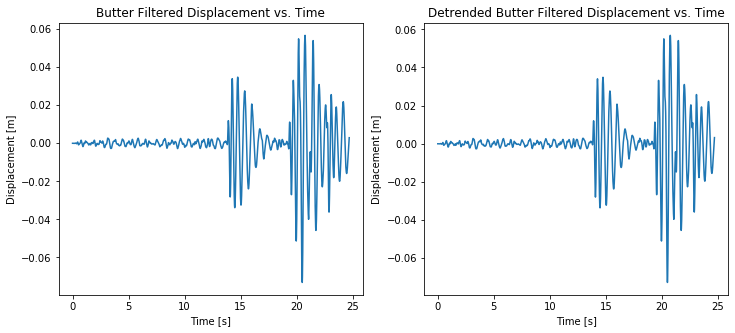

Done.
Significant wave height calculated as:  2.1518643712532697  for session  3
Actual wave height:  0.70104
Percent error:  206.95315121152427


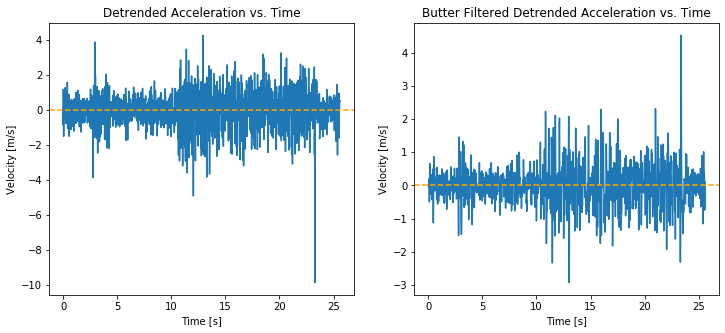

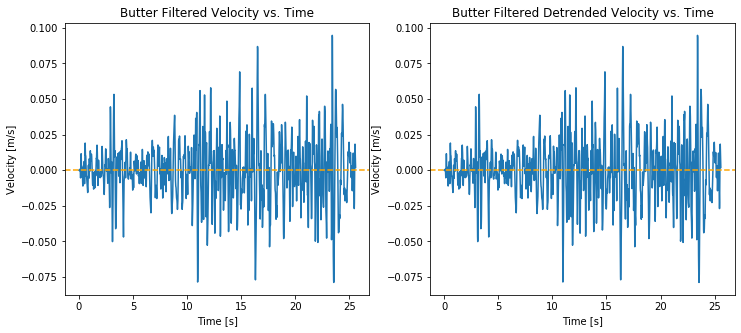

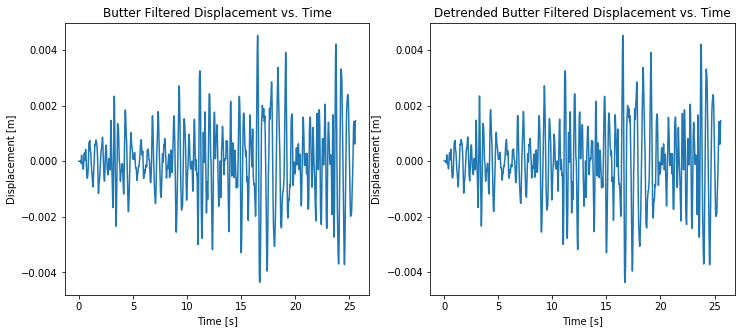

Done.
Significant wave height calculated as:  0.7993864347581887  for session  4
Actual wave height:  0.710184
Percent error:  12.56046809815325


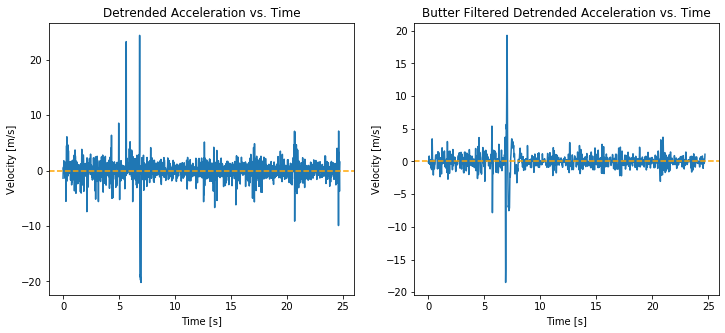

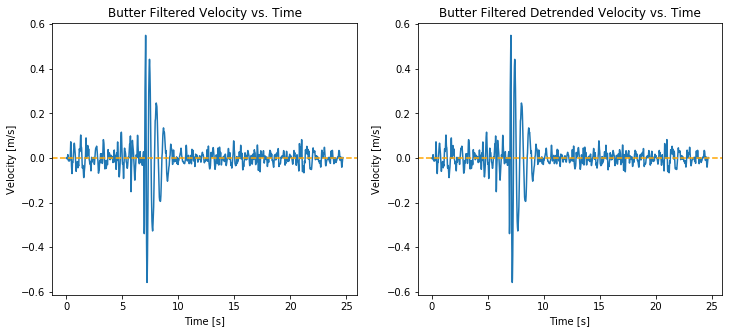

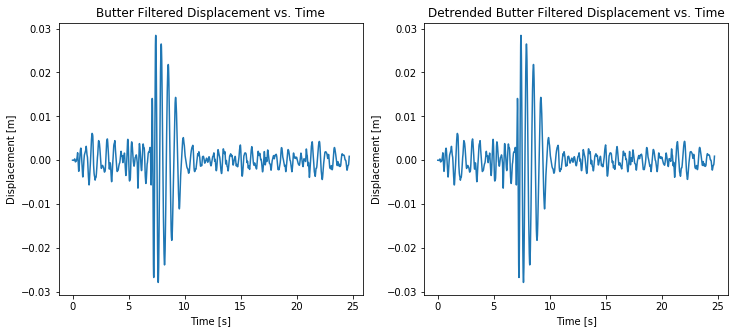

Done.
Significant wave height calculated as:  1.2195123482364254  for session  5
Actual wave height:  1.069848
Percent error:  13.989309531487232


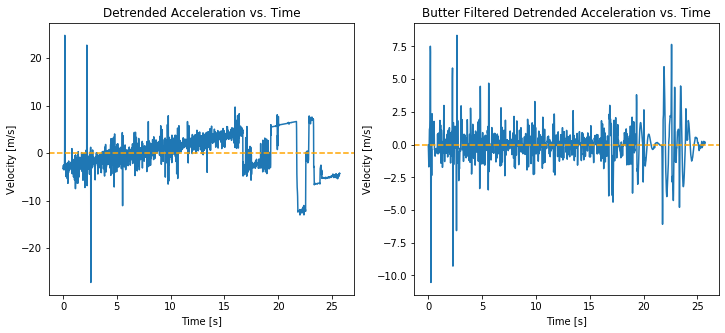

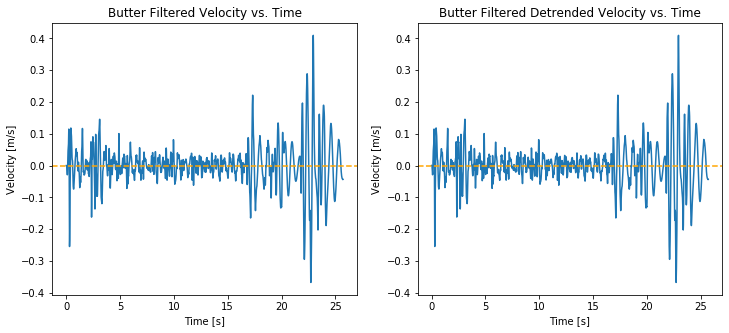

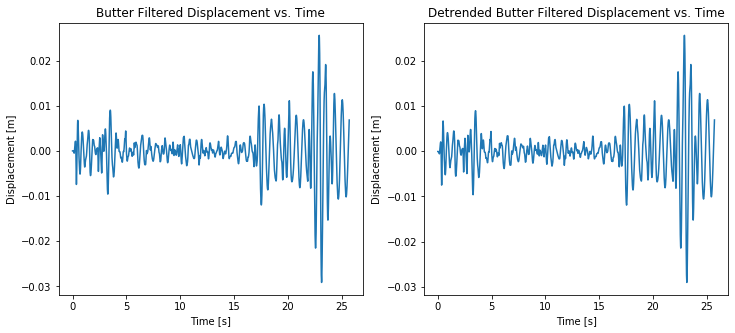

Done.
Significant wave height calculated as:  4.04348012415839  for session  6
Actual wave height:  1.179576
Percent error:  242.79097948401716


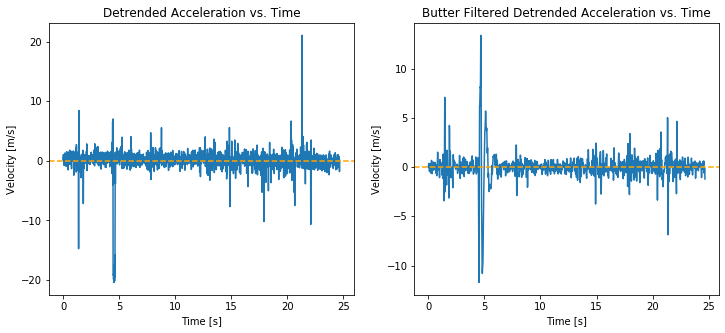

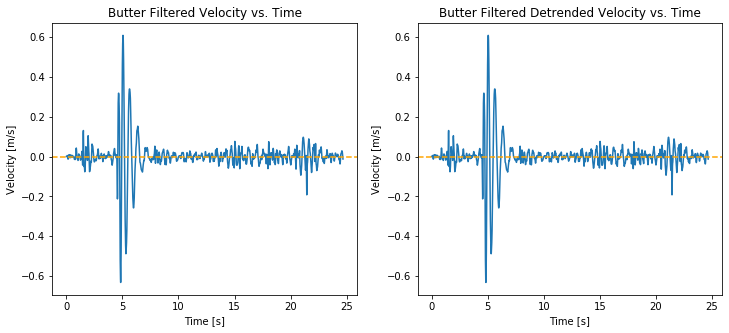

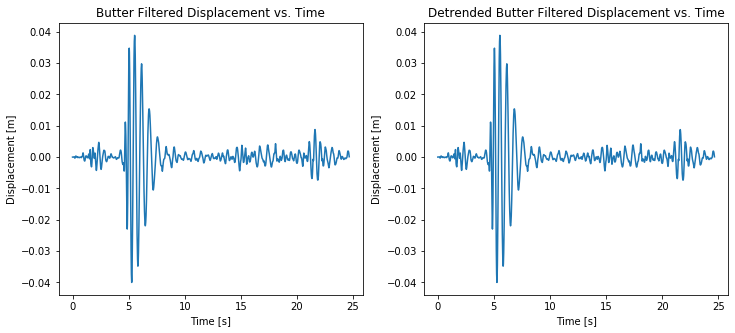

Done.
Significant wave height calculated as:  1.0008759635447984  for session  7
Actual wave height:  0.618744
Percent error:  61.75930005701847


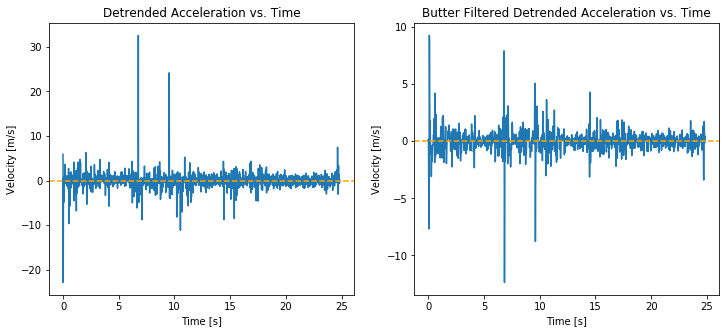

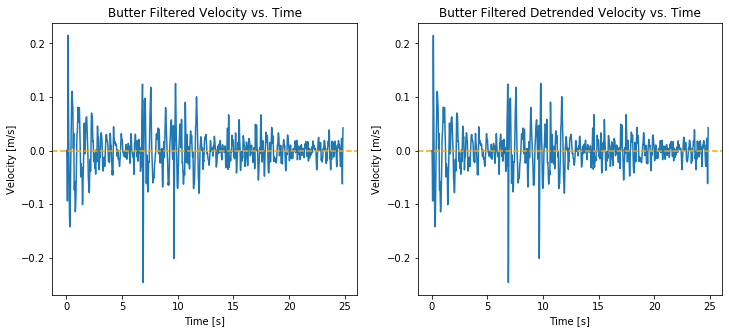

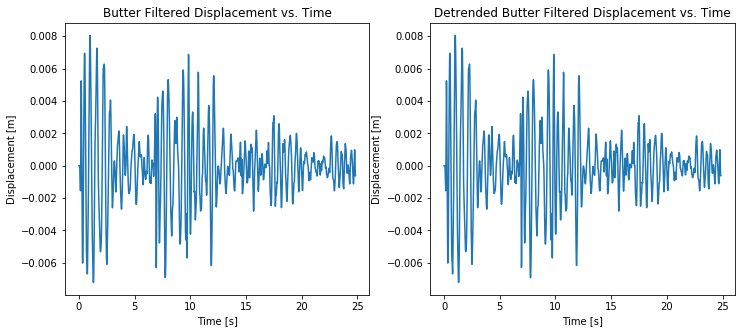

Done.
Significant wave height calculated as:  0.8517235712999671  for session  8
Actual wave height:  0.649224
Percent error:  31.1910174762435


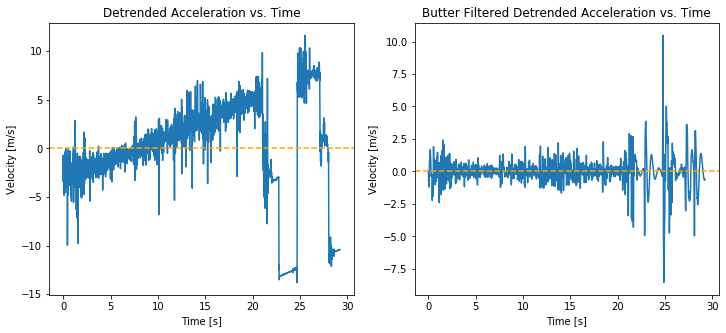

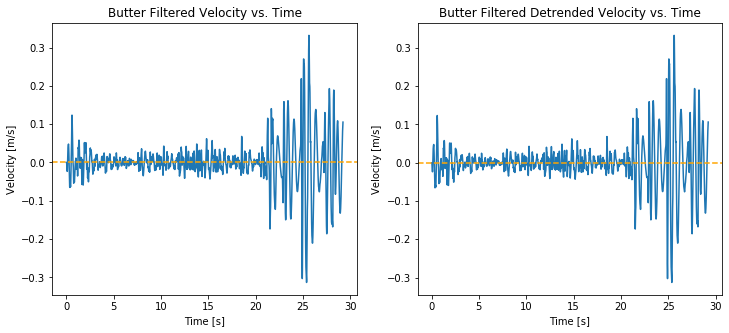

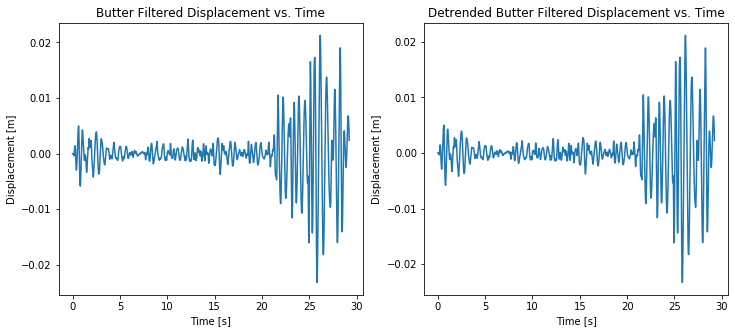

Done.
Significant wave height calculated as:  4.679880715377715  for session  9
Actual wave height:  0.9204959999999999
Percent error:  408.4085879110519


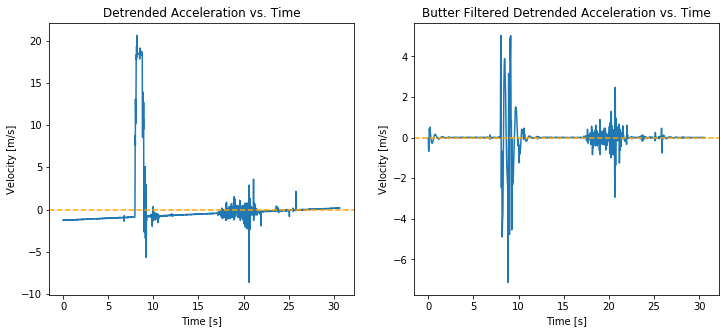

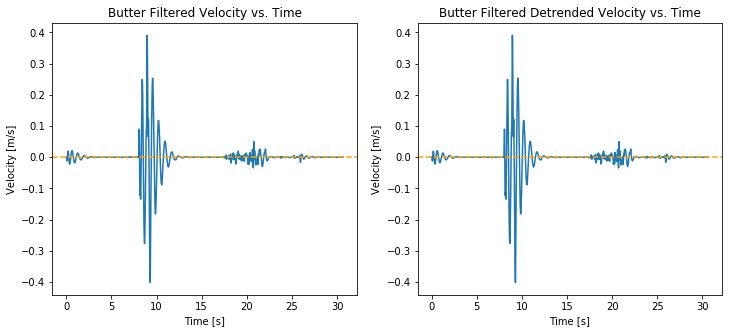

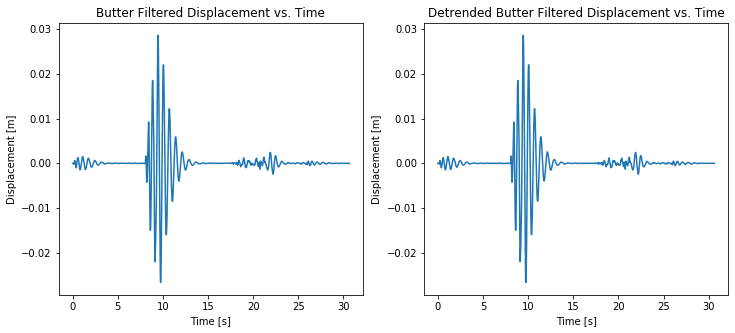

Done.
Significant wave height calculated as:  0.03167648676400159  for session  10
Actual wave height:  0.911352
Percent error:  96.52423138765246


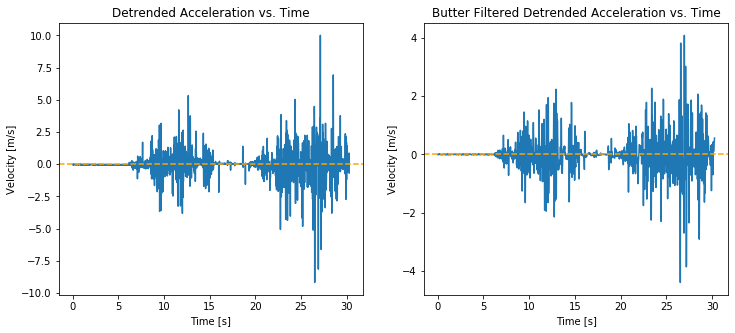

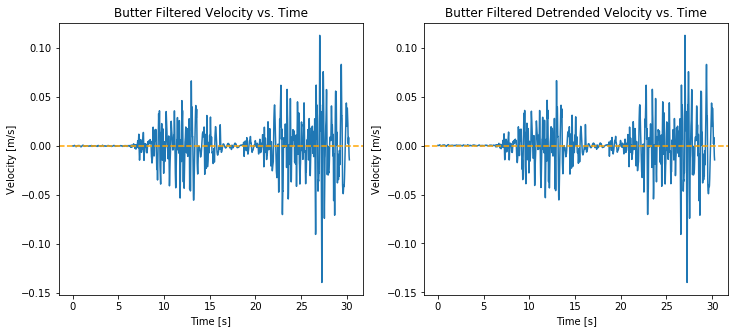

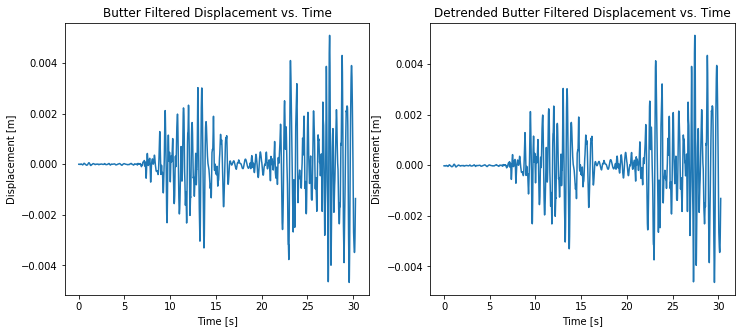

Done.
Significant wave height calculated as:  0.4009057050214402  for session  11
Actual wave height:  0.890016
Percent error:  54.9552249598389


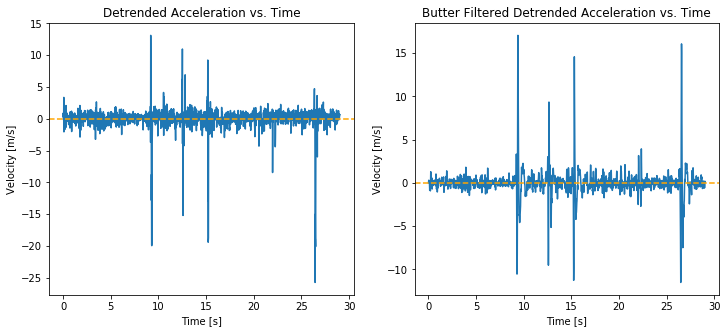

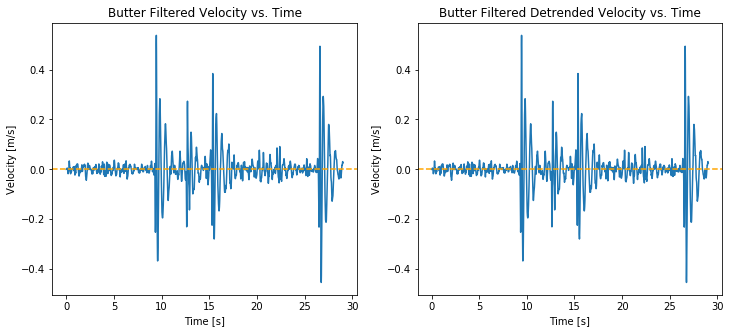

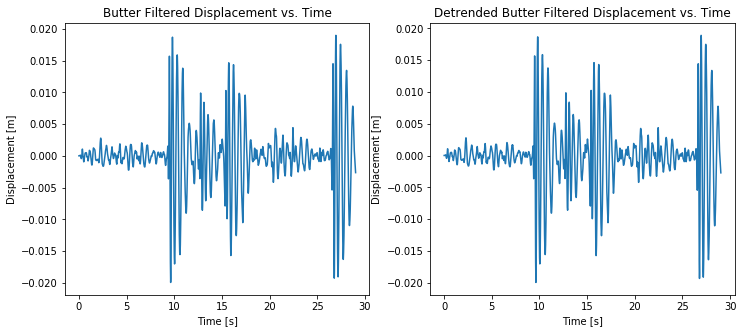

Done.
Significant wave height calculated as:  0.8684835200966354  for session  12
Actual wave height:  0.810768
Percent error:  7.118623341897483


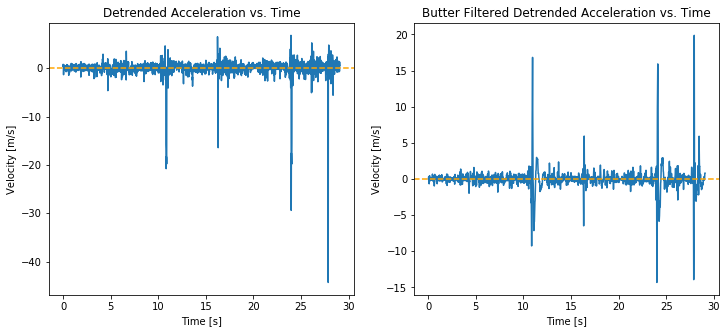

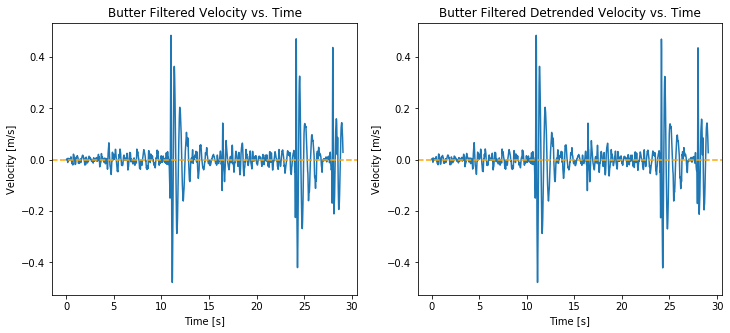

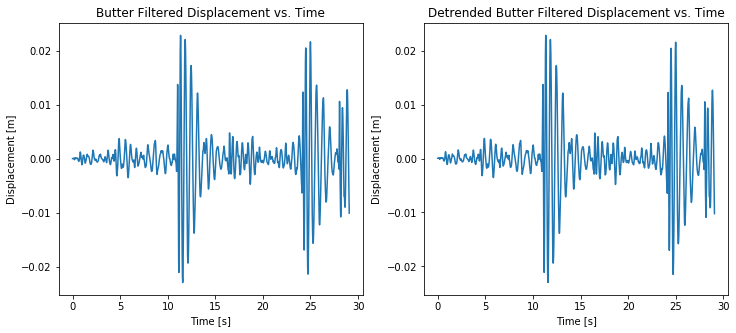

Done.
Significant wave height calculated as:  0.8490984077721198  for session  13
Actual wave height:  0.7985760000000001
Percent error:  6.3265622523240985


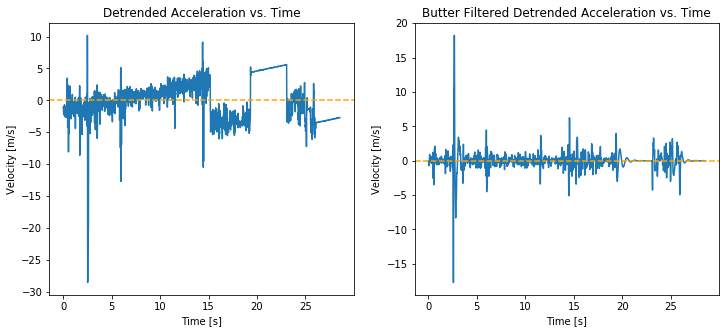

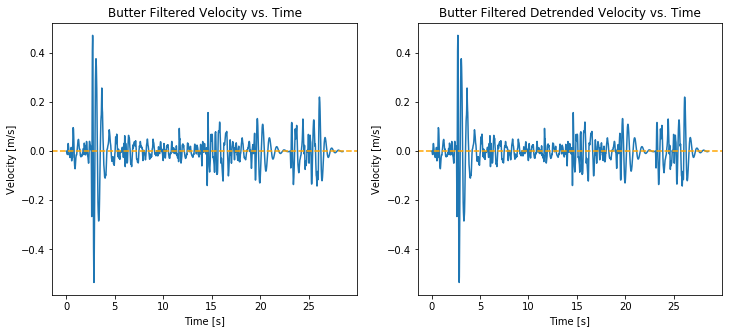

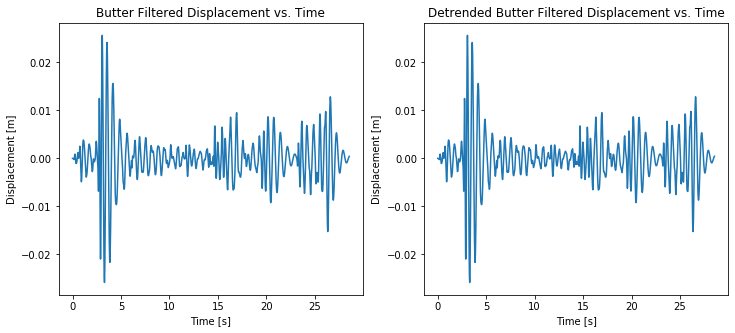

Done.
Significant wave height calculated as:  3.1683588051070366  for session  14
Actual wave height:  0.780288
Percent error:  306.0499206840342


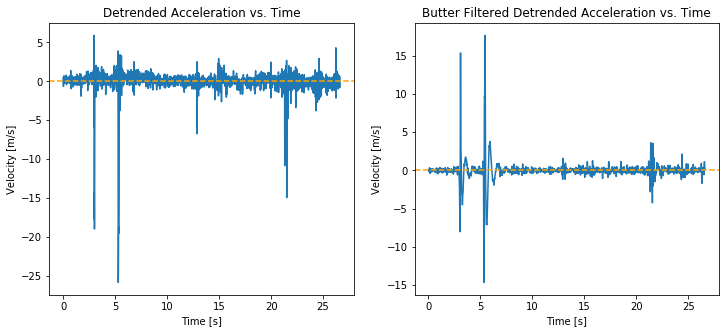

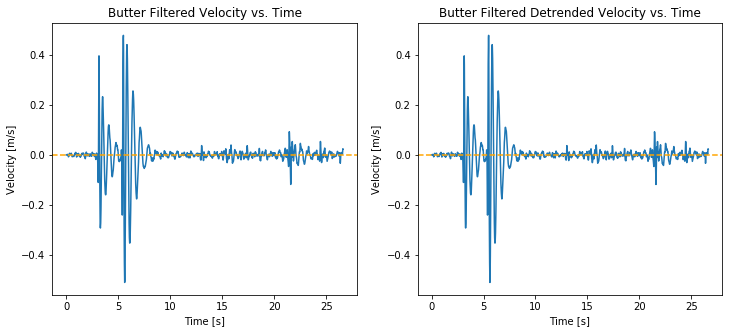

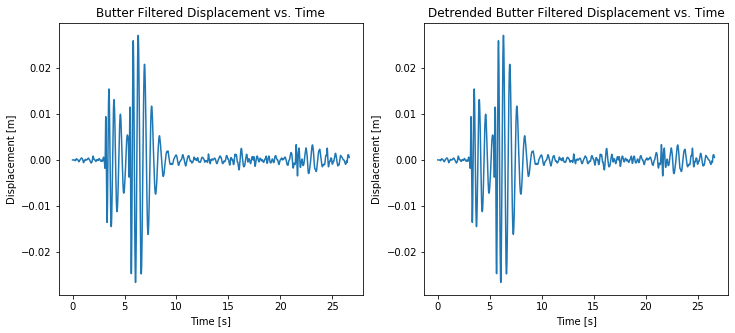

Done.
Significant wave height calculated as:  0.679748943658514  for session  15
Actual wave height:  0.810768
Percent error:  16.159870189929304


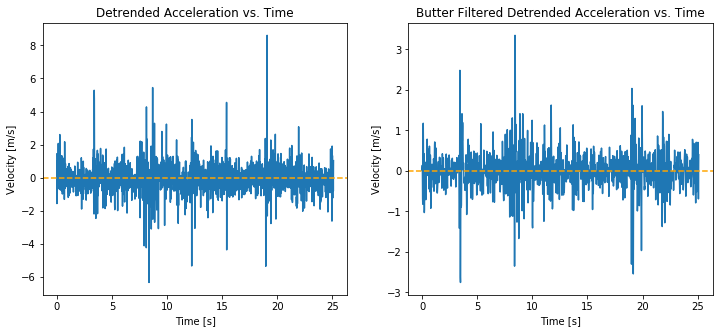

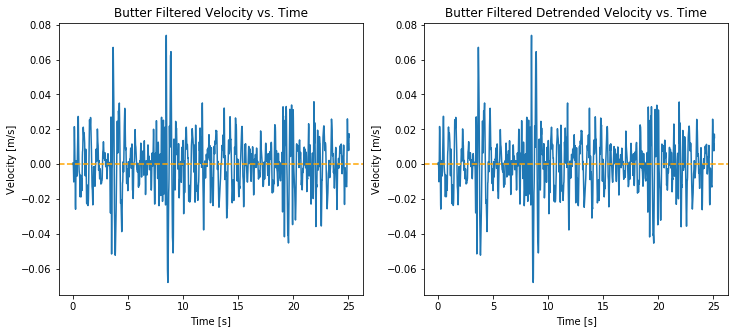

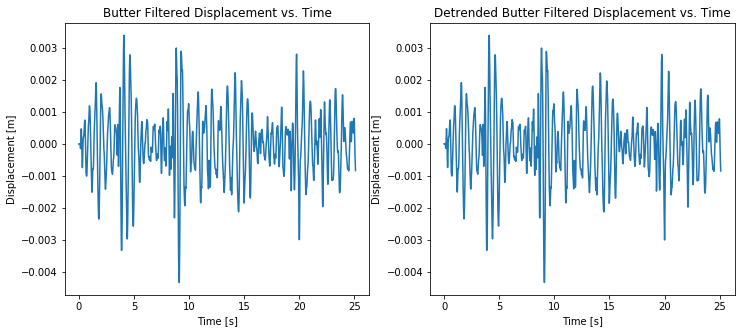

Done.
Significant wave height calculated as:  0.6660641271923726  for session  16
Actual wave height:  0.789432
Percent error:  15.62742235019956


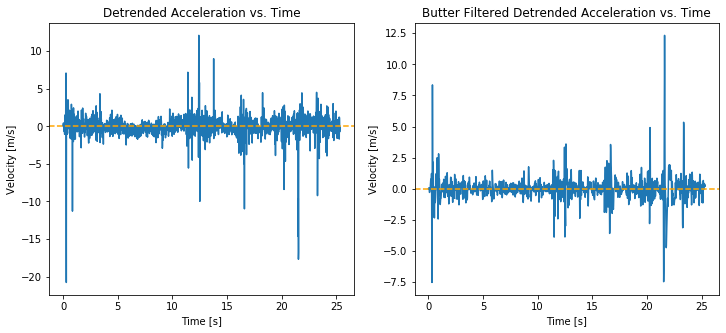

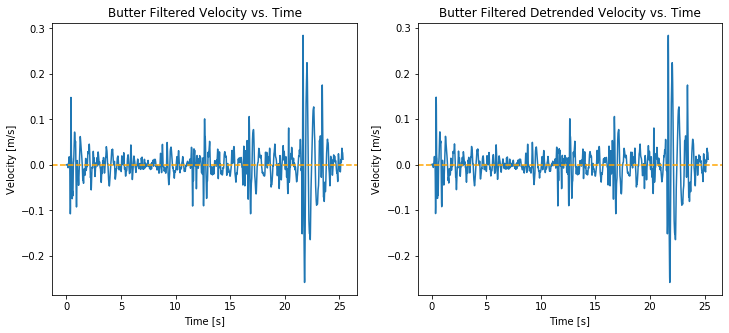

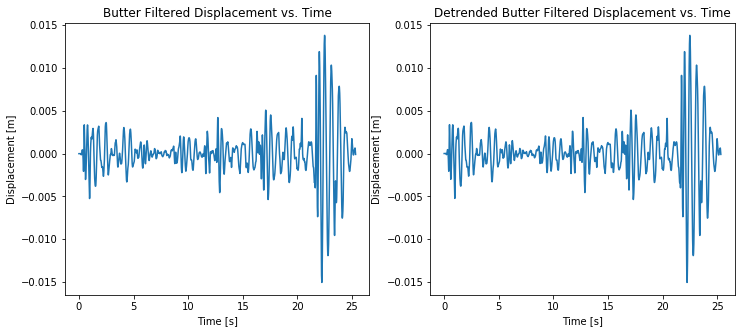

Done.
Significant wave height calculated as:  0.8924216114506152  for session  17
Actual wave height:  0.841248
Percent error:  6.083058913734733


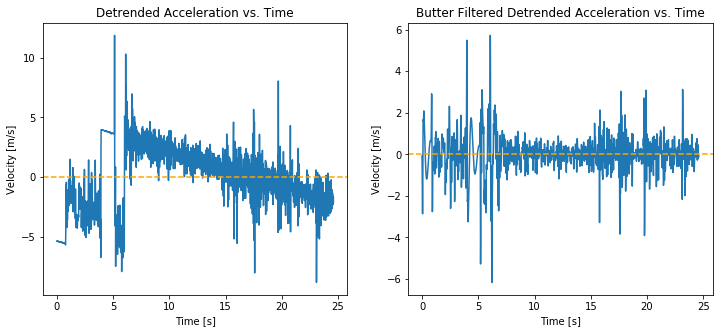

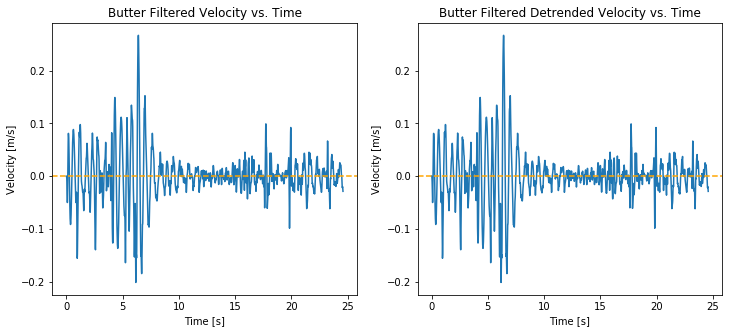

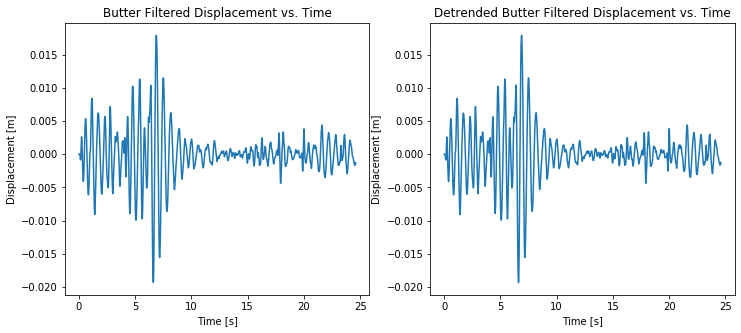

Done.
Significant wave height calculated as:  2.551287261540079  for session  18
Actual wave height:  0.841248
Percent error:  203.27409533693736


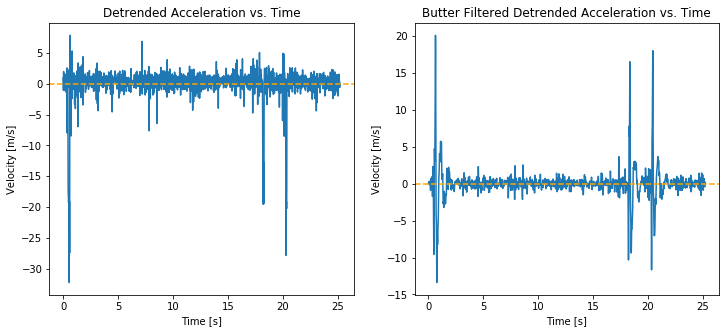

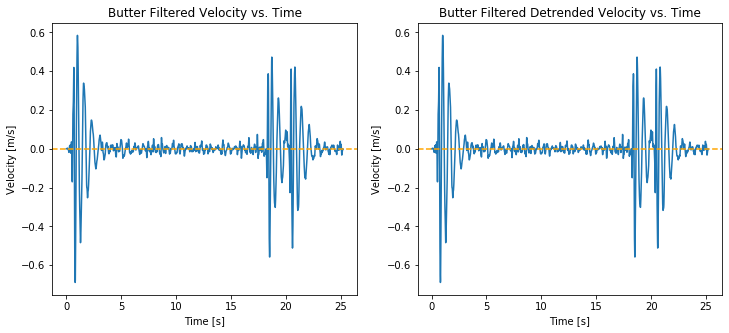

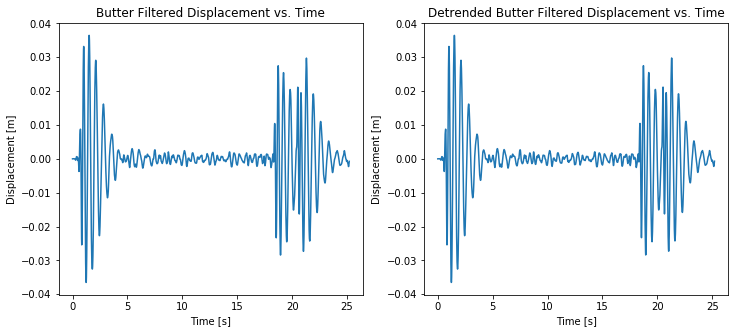

Done.
Significant wave height calculated as:  1.1623996873776576  for session  19
Actual wave height:  0.841248
Percent error:  38.1756256630218


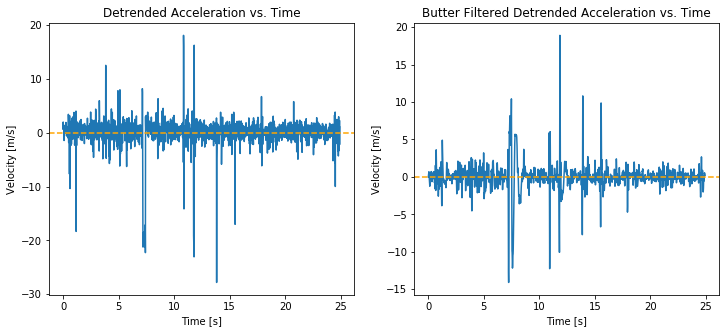

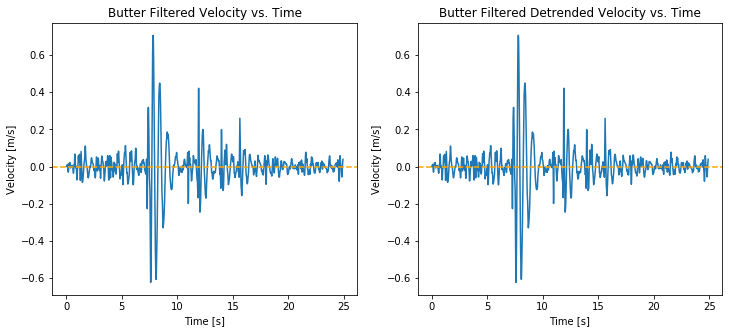

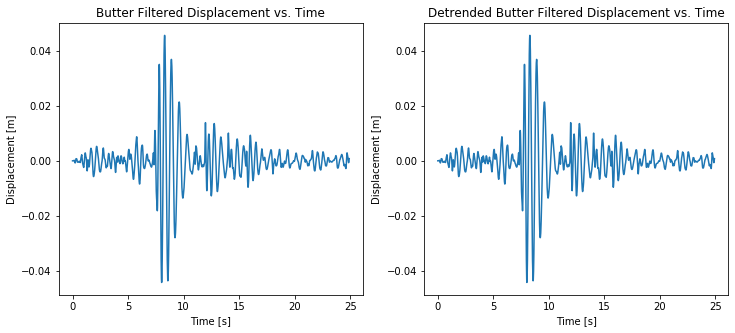

Done.
Significant wave height calculated as:  1.3990871727287644  for session  20
Actual wave height:  0.6888479999999999
Percent error:  103.10535455263927


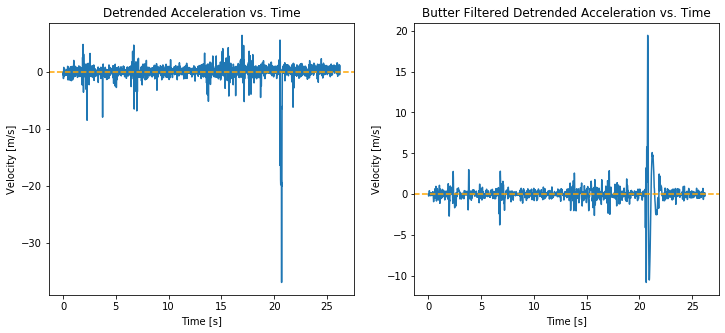

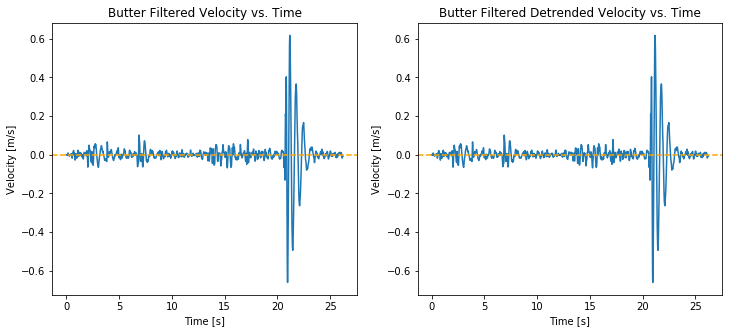

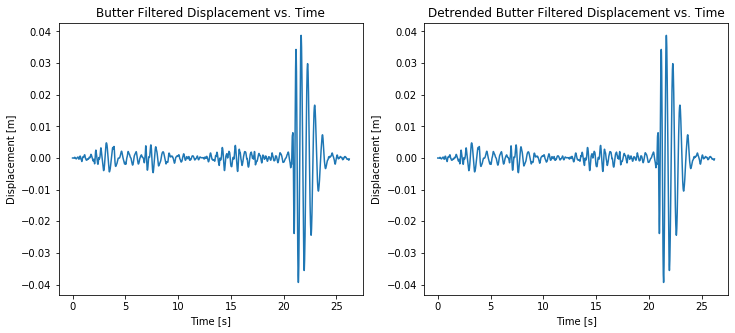

Done.
Significant wave height calculated as:  0.7797981103533074  for session  21
Actual wave height:  0.9296399999999999
Percent error:  16.118270475312222


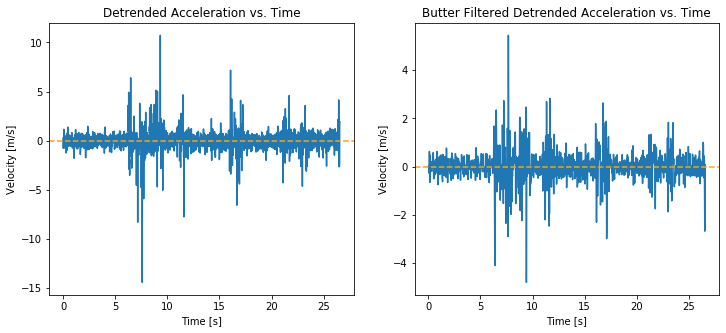

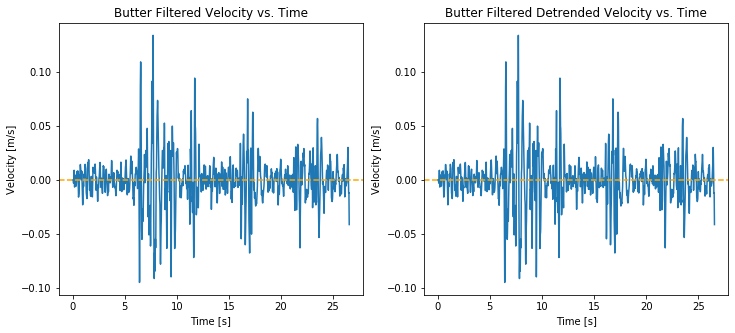

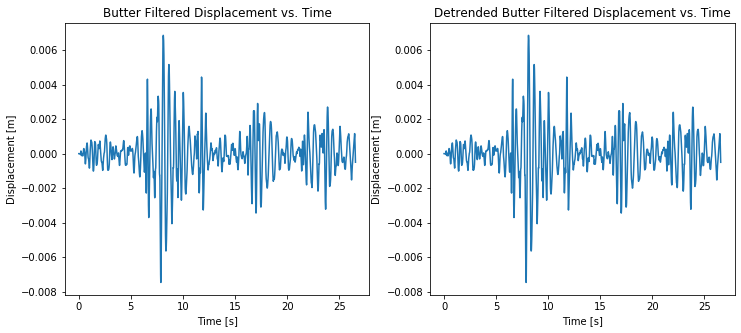

Done.
Significant wave height calculated as:  0.5700925632382621  for session  22
Actual wave height:  0.841248
Percent error:  32.23252082165282


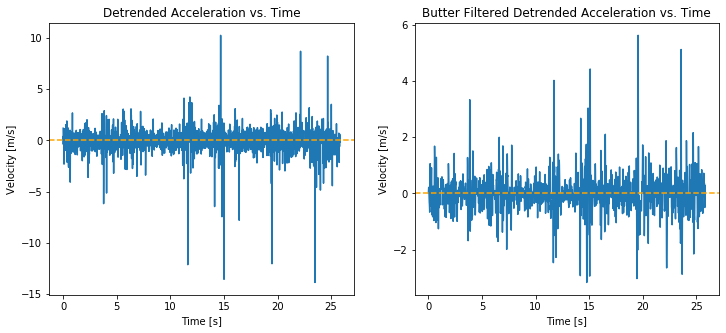

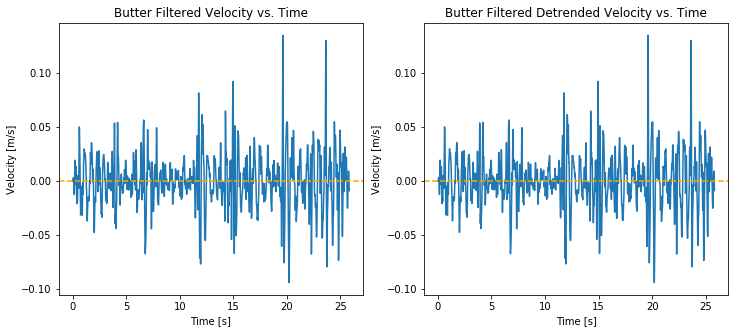

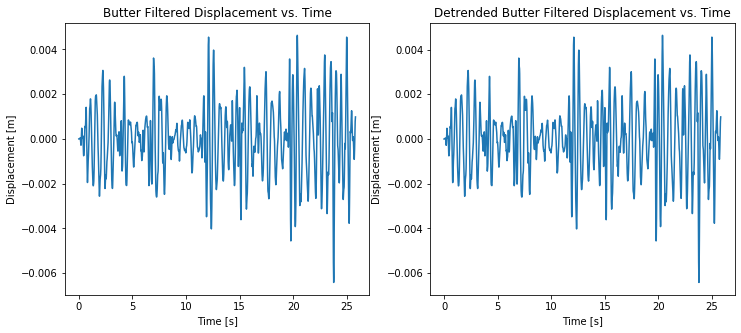

Done.
Significant wave height calculated as:  0.7681866204605381  for session  23
Actual wave height:  0.780288
Percent error:  1.550886280381332


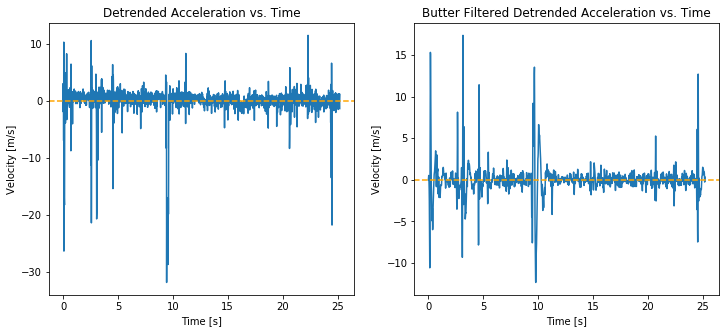

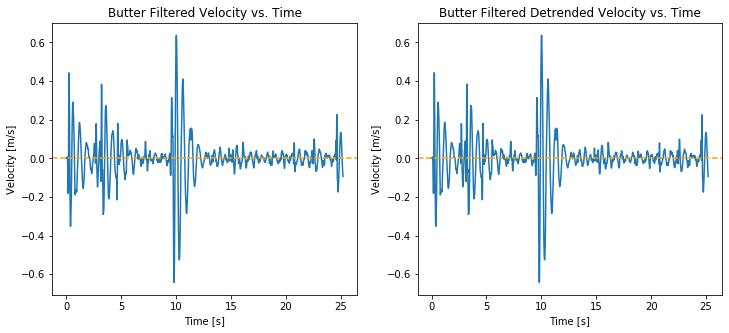

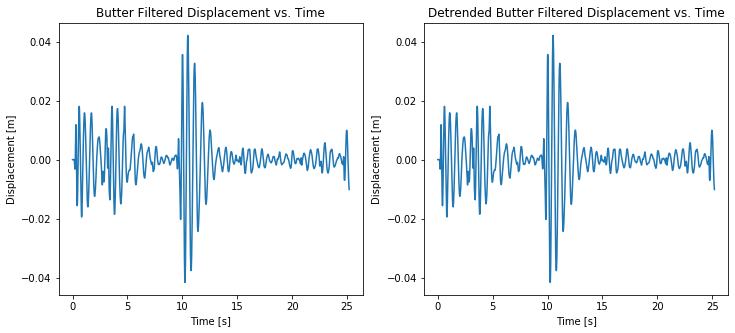

Done.
Significant wave height calculated as:  1.1526689942476596  for session  24
Actual wave height:  1.118616
Percent error:  3.044207685895741


In [11]:
# Note: acc_array = acc_list = imu2_array = imu_array2
# ALL CODE RELATED TO PLOTTING INDIVIDUAL GRAPHS HAS BEEN COMMENTED OUT

print("Starting full data set analysis:")
avg_error_list = []
expected_heights = []
difference = []

for index in range(0, len(surf_sessions)):

    acc_array = surf_sessions[index]
    dacc_test_array = signal.detrend(acc_array)

    butter_t_lfilter = butter_bandpass_lfilter(dacc_test_array, lowcut, highcut, fs, order=5)
    butter_t_filtfilt = butter_bandpass_filtfilt(dacc_test_array, lowcut, highcut, fs, order=5)

    ##For entire data:
    #Get as close to just the signal (don't want noise)    
    new_t_test, new_acc_test = calculate_new_range(time_array, acc_array, 0, 1800)
    new_t_test, new_dacc_test = calculate_new_range(time_array, dacc_test_array, 0, 1800)
    disp_butter_integral_t = double_integral_bandpass(new_t_test, new_acc_test, new_dacc_test, lowcut, highcut, fs, order)
    print("Done.")

    new_dacc = np.array(new_dacc_test)
    new_t = np.array(new_t_test)

    # Use largest third method with medians
    n = int(len(new_dacc)/3)
    xn = new_dacc
    largest_third = (xn[np.argsort(xn)[-n:]])

    exp_wave_height = abs(np.median(largest_third))
    expected_heights.append(exp_wave_height)
    # Note: arbitrarily dividing exp_wave_height by 1.1 yields a lower % error 
    
    actual = height_labels[index]
    err = percent_error(actual, exp_wave_height)
    avg_error_list.append(err)
    difference.append(abs(err*actual/100))
    
    print("Significant wave height calculated as: ", exp_wave_height, " for session ", index+1)
    print("Actual wave height: ", actual)
    print("Percent error: ", err)

# Calculate Outlier Sessions

In [12]:
# Traditional Tukey's Fences method of calculating outliers
median = np.quantile(difference, .50)
q1 = np.quantile(difference, .25) 
q3 = np.quantile(difference, .75)

# Get inter-quartile range
iqr = q3-q1
over_outlier = q3+(iqr*1.5)
under_outlier = q1-(iqr*1.5)

# 3 standard deviations above the mean method
# mean = statistics.mean(difference)
# stdev = statistics.stdev(difference)
# over_outlier = mean+(stdev*3)
# under_outlier = mean-(stdev*3)

print('High outlier:', over_outlier)
print('Low outlier:', under_outlier)

# Generate outlier sessions array
outlier_sessions_index = []
for i in range(0, len(difference)):
    if (difference[i]<under_outlier or difference[i]>over_outlier):
        outlier_sessions_index.append(i)
        print('\nSession', i+1)
        print('Difference', difference[i])
        
print(len(outlier_sessions_index), 'sessions')

High outlier: 1.7477063045628016
Low outlier: -0.9059151533231411

Session 6
Difference 2.86390412415839

Session 9
Difference 3.759384715377715

Session 14
Difference 2.3880708051070365
3 sessions


## Graph data

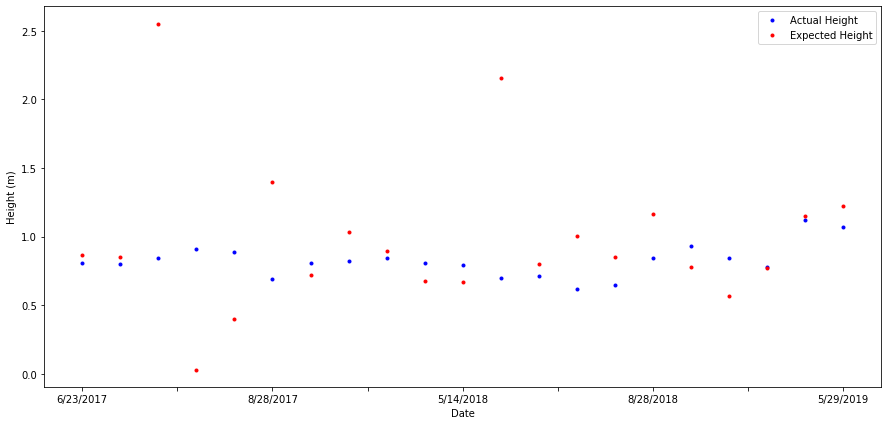


Mean error:  74.5787106494022
Median error:  26.099360983701057


In [13]:
# x-axis will be dates of surf sessions, sorted
# y-axis will be their corresponding actual height and expected height values

# Build dataframe and sort by UTC time
data_to_plot = list(zip(utc_labels, date_labels, height_labels, expected_heights))

plot_df = pd.DataFrame(data_to_plot, columns=['UTC', 'Date', 'Actual Height', 'Expected Height'])
plot_df.drop(outlier_sessions_index, inplace=True)
plot_df.sort_values('UTC', inplace=True)

ax = plt.gca()
plot_df.plot(x='Date', y='Actual Height', color='blue', ax=ax, style='.', figsize=(15,7))
plot_df.plot(x='Date', y='Expected Height', color='red', ax=ax, style='.')
plt.xlabel('Date')
plt.ylabel('Height (m)')
plt.show()

# Error after removing outliers
for index in outlier_sessions_index:
    del avg_error_list[index]
    
print("\nMean error: ", statistics.mean(avg_error_list))
print("Median error: ", statistics.median(avg_error_list))